In this file, KNN algorithm is experimented with sklearn.neighbors.KNeighborsClassifier.

Source: https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

The result is displayed with IOU metric with sklearn.metrics.jaccard_score.

Source: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.jaccard_score.html

In [1]:
import os
import glob
import json
import pandas as pd 
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import skimage.io as io
import skimage.color as color
from matplotlib import pyplot as plt
from pprint import pprint
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
import cv2
from sklearn.metrics import classification_report, jaccard_score

Processing the training and testing data

In [2]:
path = "turtles-data/data/"
with open(f"{path}annotations.json", 'r', encoding='utf8') as file:
    data = json.load(file)

In [4]:
csv = pd.read_csv(f"{path}metadata_splits.csv")
coco = COCO(f"{path}annotations.json")

loading annotations into memory...
Done (t=6.59s)
creating index...
index created!


In [5]:
# Split based on split_open given by dataset
train_data = csv[csv["split_open"] == "train"]
test_data = csv[csv["split_open"] == "test"]

# List of ids
train_ids = train_data["id"].tolist()
test_ids = test_data["id"].tolist()

In [6]:
# Everything into Grayscale
X_path = [path + coco.imgs[id]['file_name'] for id in train_ids]
X_train_grayimage = [cv2.resize(cv2.imread(x, cv2.IMREAD_GRAYSCALE), (256,256)).flatten() for x in X_path]

In [7]:
Y_train_mask = []
for x in train_ids:
    annId = coco.getAnnIds(x)
    anns = coco.loadAnns(annId)
    if len(anns) != 0:
      mask = coco.annToMask(anns[0])
      for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    Y_train_mask.append(cv2.resize(mask, (256,256)).flatten())

In [9]:
# Everything into grayscale
test_path = [path + coco.imgs[id]['file_name'] for id in test_ids]
test_grayimage = [cv2.resize(cv2.imread(y, cv2.IMREAD_GRAYSCALE), (256,256)).flatten() for y in test_path]

In [10]:
Y_test_mask = []
for y in test_ids:
    annId = coco.getAnnIds(y)
    anns = coco.loadAnns(annId)
    if len(anns) != 0:
      mask = coco.annToMask(anns[0])
      for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    Y_test_mask.append(cv2.resize(mask, (256,256)).flatten())

### KNN with Grayscale Input

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_grayimage, Y_train_mask)

KNeighborsClassifier()

In [12]:
knn_predict = knn.predict(test_grayimage)

In [13]:
test_pixels = np.array(Y_test_mask)
test_flat_pixels = test_pixels.flatten()

In [16]:
pred_pixels = np.array(knn_predict)
pred_flat_pixels = pred_pixels.flatten()

In [17]:
iou_mean = jaccard_score(test_flat_pixels, pred_flat_pixels, average="macro")

In [18]:
iou_back, iou_cara, iou_flip, iou_head, _ = jaccard_score(test_flat_pixels, pred_flat_pixels, average=None)

In [19]:
print("Grayscale Image")
print(f"Mean IOU: {iou_mean}")
print(f"Background IOU: {iou_back}")
print(f"Carapace IOU: {iou_cara}")
print(f"Flipper IOU: {iou_flip}")
print(f"Head IOU: {iou_head}")

Grayscale Image
Mean IOU: 0.2014760792121153
Background IOU: 0.8815796917008171
Carapace IOU: 0.10496431296117911
Flipper IOU: 0.016491115354819674
Head IOU: 0.0043452760437605945


Appearently, the information in grayscaled image is limited. Including RGB maybe a good idea, but what if XY coordinates is also included?

### Visualization for KNN with Grayscale

In [20]:
# Sample Index
# Parameter that index can be choose within 0 to len(test_ids) - 1 = 2307, Used to show true mask and predicted mask
sample_index = 0 
sample_index_1 = 233
# Used to show original image and mask without resize
image_index = test_ids[sample_index]
image_index_1 = test_ids[sample_index_1]
# Help function to show the original image and mask
def showImbyId(idx):
    info = coco.loadImgs(idx)[0]
    temp = path + info['file_name']
    img = cv2.imread(temp)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def showMaskbyId(idx):
    annId = coco.getAnnIds(idx)
    anns = coco.loadAnns(annId)
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    plt.imshow(mask)

In [21]:
# Load resized pred and mask
sample = test_pixels[sample_index]
sample_mask = pred_pixels[sample_index]

Original sample input and sample mask for latter display

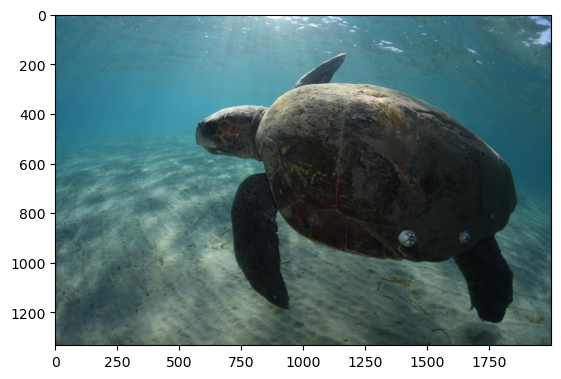

In [22]:
showImbyId(image_index)

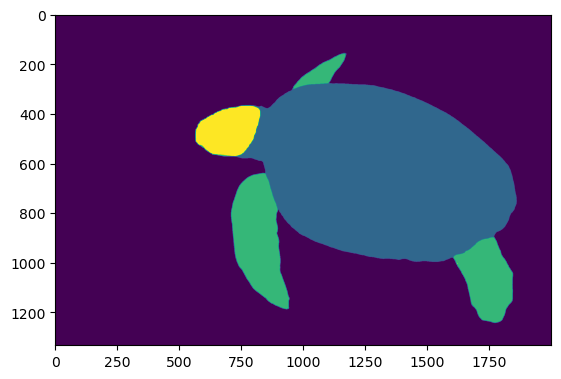

In [23]:
showMaskbyId(image_index)

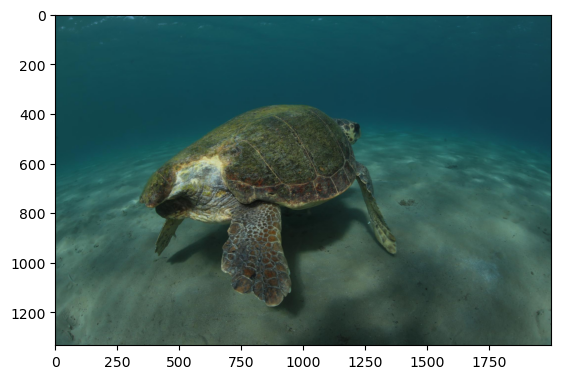

In [24]:
showImbyId(image_index_1)

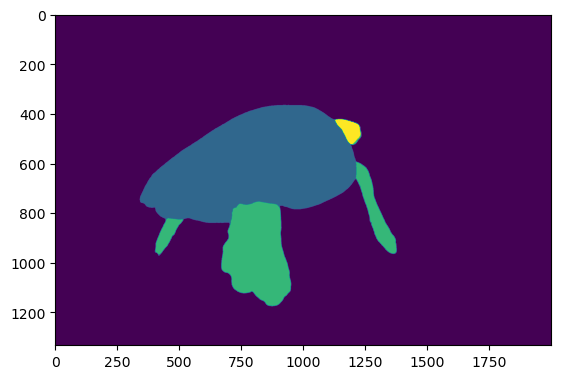

In [25]:
showMaskbyId(image_index_1)

Resized true mask and predicted mask

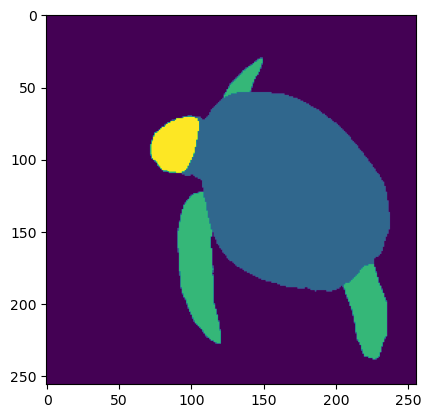

In [26]:
plt.imshow(sample.reshape(256, 256))

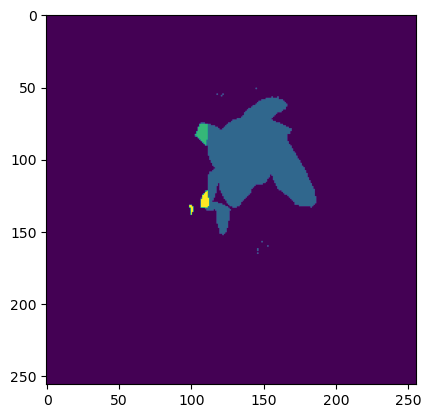

In [27]:
plt.imshow(sample_mask.reshape(256, 256))

In [28]:
# Load resized mask and pred
sample_1 = test_pixels[sample_index_1]
sample_mask_1 = pred_pixels[sample_index_1]

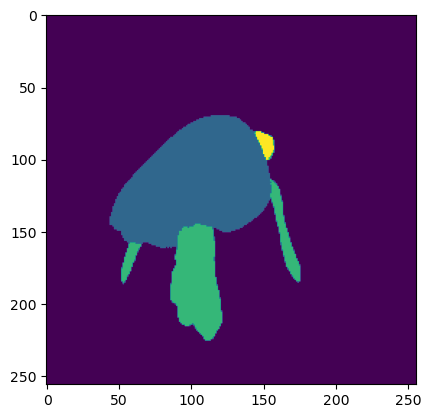

In [29]:
plt.imshow(sample_1.reshape(256, 256))

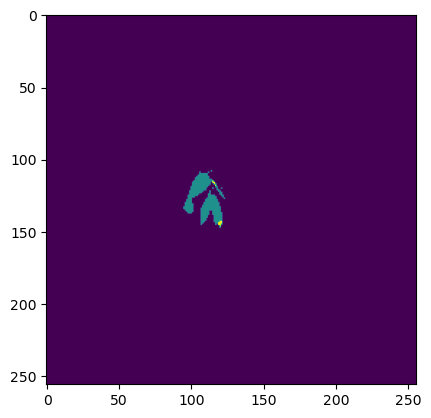

In [30]:
plt.imshow(sample_mask_1.reshape(256, 256))

### KNN with Grayscale Input (Same Training and Testing Set)

As loading RGBXY require more memory, another version of grayscale input is made to compare with latter result. This ensure a different result is not caused by the change of training/testing size.

In [53]:
LIMITED_TRAIN_SIZE = 1500
LIMITED_TEST_SIZE = 500

In [55]:
Y_train_mask_1 = Y_train_mask[:LIMITED_TRAIN_SIZE]
X_train_grayimage_1 = X_train_grayimage[:LIMITED_TRAIN_SIZE]
Y_test_mask_1 = Y_test_mask[:LIMITED_TEST_SIZE]
test_grayimage_1 = test_grayimage[:LIMITED_TEST_SIZE]

In [57]:
knn_1 = KNeighborsClassifier(n_neighbors=5)
knn_1.fit(X_train_grayimage_1, Y_train_mask_1)

KNeighborsClassifier()

In [58]:
knn_predict_1 = knn.predict(test_grayimage_1)

In [59]:
test_pixels_1 = np.array(Y_test_mask_1)
test_flat_pixels_1 = test_pixels_1.flatten()

In [60]:
pred_pixels_1 = np.array(knn_predict_1)
pred_flat_pixels_1 = pred_pixels_1.flatten()

In [61]:
iou_mean = jaccard_score(test_flat_pixels_1, pred_flat_pixels_1, average="macro")

In [62]:
iou_back, iou_cara, iou_flip, iou_head, _ = jaccard_score(test_flat_pixels_1, pred_flat_pixels_1, average=None)

In [63]:
print("Grayscale Image with Same Training and Testing Set")
print(f"Mean IOU: {iou_mean}")
print(f"Background IOU: {iou_back}")
print(f"Carapace IOU: {iou_cara}")
print(f"Flipper IOU: {iou_flip}")
print(f"Head IOU: {iou_head}")

Grayscale Image with Same Training and Testing Set
Mean IOU: 0.20132065952625275
Background IOU: 0.8736180834171254
Carapace IOU: 0.11421843072214637
Flipper IOU: 0.011996623669767472
Head IOU: 0.006770159822224454


The IOU is still poor with less training and testing.

### KNN with RGBXY input

Processing input

In [65]:
# 1500 image read in RGB for training, reduced input size to avoid out of memory
X_train_RGBimage = [cv2.resize(cv2.imread(x), (256,256)) for x in X_path[:LIMITED_TRAIN_SIZE]]

In [66]:
# 500 image read in RGB for testing
test_RGBimage = [cv2.resize(cv2.imread(y), (256,256)) for y in test_path[:LIMITED_TEST_SIZE]]

In [67]:
# Attach the XY Label
cood_RGBimage = []
for img in X_train_RGBimage:
    cood_img = []
    for y, row in enumerate(img):
        for x, pixel in enumerate(row):
            cood_img.append(np.hstack((pixel, [x,y])))
    cood_RGBimage.append(cood_img)

In [68]:
# A Sample Image Input after Processing
cood_RGBimage[0]

[array([178, 150, 116,   0,   0]),
 array([199, 167, 146,   1,   0]),
 array([201, 162, 133,   2,   0]),
 array([228, 178, 156,   3,   0]),
 array([227, 176, 144,   4,   0]),
 array([221, 173, 148,   5,   0]),
 array([252, 196, 171,   6,   0]),
 array([228, 179, 165,   7,   0]),
 array([243, 205, 182,   8,   0]),
 array([245, 205, 193,   9,   0]),
 array([254, 209, 198,  10,   0]),
 array([227, 201, 174,  11,   0]),
 array([246, 209, 224,  12,   0]),
 array([240, 210, 191,  13,   0]),
 array([247, 222, 212,  14,   0]),
 array([217, 190, 170,  15,   0]),
 array([238, 205, 199,  16,   0]),
 array([227, 202, 183,  17,   0]),
 array([255, 221, 211,  18,   0]),
 array([250, 214, 208,  19,   0]),
 array([252, 220, 200,  20,   0]),
 array([255, 223, 214,  21,   0]),
 array([215, 187, 173,  22,   0]),
 array([255, 228, 224,  23,   0]),
 array([254, 226, 220,  24,   0]),
 array([251, 233, 219,  25,   0]),
 array([235, 214, 205,  26,   0]),
 array([218, 201, 174,  27,   0]),
 array([196, 171, 13

In [69]:
# Flatten all image into one pixel array
train_RGBCoodimage = np.array(cood_RGBimage)
flat_train_images = train_RGBCoodimage.reshape(-1, 5)

In [70]:
# Flatten all mask into one pixel array
flat_train_mask = np.array(Y_train_mask[:LIMITED_TRAIN_SIZE]).flatten()

In [71]:
# Processing Test inputs
cood_RGB_testimage = []
for test_image in test_RGBimage[:LIMITED_TEST_SIZE]:
    cood_img = []
    for y, row in enumerate(test_image):
        for x, pixel in enumerate(row):
            cood_img.append(np.hstack((pixel, [x,y])))
    cood_RGB_testimage.append(cood_img)

In [72]:
# Processing test mask for calculate IOU score 
tested_mask = (np.array(Y_test_mask[:LIMITED_TEST_SIZE])).flatten()

Training and Testing

In [73]:
RGBknn = KNeighborsClassifier(n_neighbors=5)

In [74]:
RGBknn.fit(flat_train_images, flat_train_mask)

KNeighborsClassifier()

In [75]:
RFBknn = RGBknn.predict((np.array(cood_RGB_testimage)).reshape(-1,5))

In [76]:
result = (np.array(RFBknn)).flatten()

In [77]:
iou_mean = jaccard_score(tested_mask, RFBknn, average="macro")

In [78]:
iou_back, iou_cara, iou_flip, iou_head, _ = jaccard_score(tested_mask, RFBknn, average=None)

In [79]:
print("KNN with RGBXY Input")
print(f"Mean IOU: {iou_mean}")
print(f"Background IOU: {iou_back}")
print(f"Carapace IOU: {iou_cara}")
print(f"Flipper IOU: {iou_flip}")
print(f"Head IOU: {iou_head}")

KNN with RGBXY Input
Mean IOU: 0.2643519268144962
Background IOU: 0.8855983977339722
Carapace IOU: 0.30140174630760236
Flipper IOU: 0.07547501322355864
Head IOU: 0.05928447680734797


Accuracy for head is the worst with the minimal amount of pixel as input, a reduce of K can increase amount of prediction in other class.

### Visualization for KNN with RGBXY

In [80]:
# Sample Index
# Parameter that index can be choose within 0 to 499, Used to show true mask and predicted mask
sample_RGB_index = 0 
sample_RGB_index_1 = 233
# Find the range of pred mask
PIXEL_NUM = 65536 # 256*256
low_bound = sample_RGB_index * PIXEL_NUM
low_bound_1 = sample_RGB_index_1 * PIXEL_NUM
upper_bound = (sample_RGB_index + 1) * PIXEL_NUM
upper_bound_1 = (sample_RGB_index_1 + 1) * PIXEL_NUM

# Pred and Mask With shape (65536,)
sample_RGB_mask = Y_test_mask[sample_RGB_index] 
sample_pred_RGB_mask = RFBknn[low_bound:upper_bound]
sample_RGB_mask_1 = Y_test_mask[sample_RGB_index_1]
sample_pred_RGB_mask_1 = RFBknn[low_bound_1:upper_bound_1]

2 samples same as above

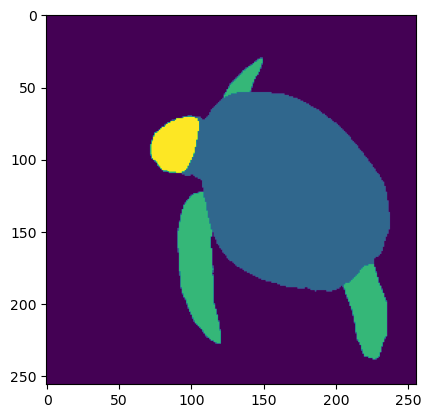

In [81]:
plt.imshow((np.array(sample_RGB_mask)).reshape(256,256))

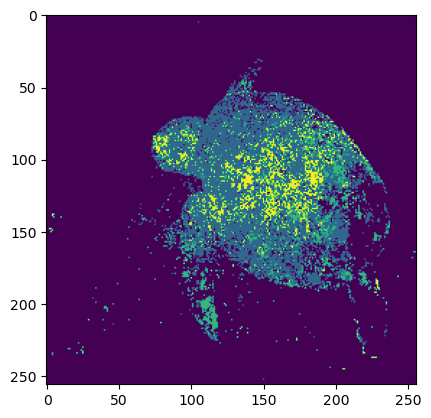

In [82]:
plt.imshow((np.array(sample_pred_RGB_mask)).reshape(256,256))

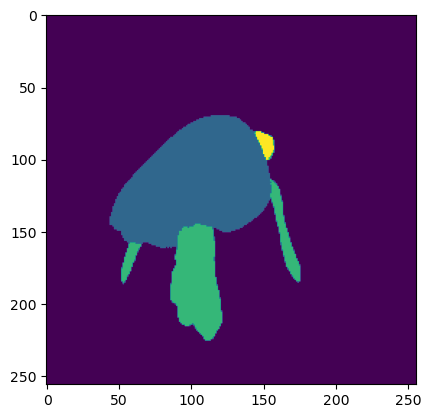

In [83]:
plt.imshow((np.array(sample_RGB_mask_1)).reshape(256,256))

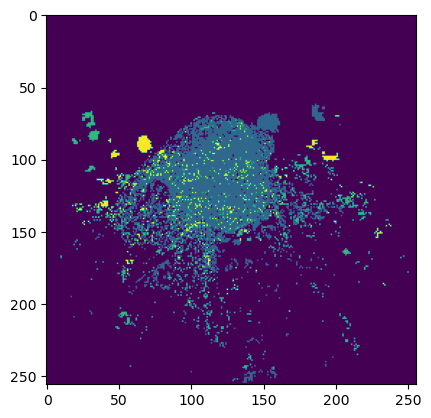

In [84]:
plt.imshow((np.array(sample_pred_RGB_mask_1)).reshape(256,256))

### KNN with RGBXY input and reduced K (3 neighbors)

In [85]:
neighbor_3 = KNeighborsClassifier(n_neighbors=3)

In [86]:
neighbor_3.fit(flat_train_images, flat_train_mask)

KNeighborsClassifier(n_neighbors=3)

In [87]:
neighbor_3_pred = neighbor_3.predict((np.array(cood_RGB_testimage)).reshape(-1,5))

In [88]:
iou_mean = jaccard_score(tested_mask, neighbor_3_pred, average="macro")

In [89]:
iou_back, iou_turt, iou_flip, iou_head, _ = jaccard_score(tested_mask, neighbor_3_pred, average=None)

In [90]:
print("KNN with RGBXY Input and reduced K")
print(f"Mean IOU: {iou_mean}")
print(f"Background IOU: {iou_back}")
print(f"Carapace IOU: {iou_cara}")
print(f"Flipper IOU: {iou_flip}")
print(f"Head IOU: {iou_head}")

KNN with RGBXY Input and reduced K
Mean IOU: 0.25909369519728986
Background IOU: 0.8769393563301547
Carapace IOU: 0.30140174630760236
Flipper IOU: 0.07452912398250902
Head IOU: 0.062254509669738625


As expected, the classes with minority pixels increased the accuracy, but the mean IOU decreased.

### Visualization for KNN with RGBXY and reduced K

In [91]:
# Similar with the above
# Sample Index
# Parameter that index can be choose within 0 to 499, Used to show true mask and predicted mask
sample_RGB3_index = 0 
sample_RGB3_index_1 = 233
# Find the range of pred mask
PIXEL_NUM = 65536 # 256*256
low_3bound = sample_RGB_index * PIXEL_NUM
low_3bound_1 = sample_RGB_index_1 * PIXEL_NUM
upper_3bound = (sample_RGB_index + 1) * PIXEL_NUM
upper_3bound_1 = (sample_RGB_index_1 + 1) * PIXEL_NUM

# Pred and Mask With shape (65536,)
sample_RGB3_mask = Y_test_mask[sample_RGB_index] 
sample_pred_RGB3_mask = neighbor_3_pred[low_bound:upper_bound]
sample_RGB3_mask_1 = Y_test_mask[sample_RGB_index_1]
sample_pred_RGB3_mask_1 = neighbor_3_pred[low_bound_1:upper_bound_1]

2 samples same as above

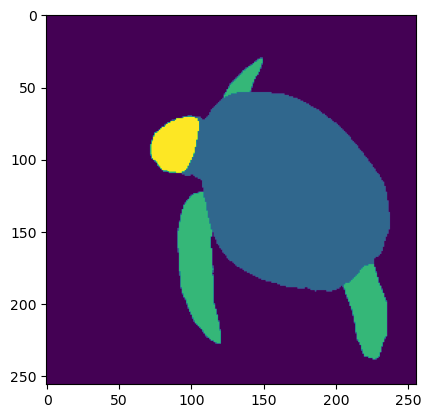

In [92]:
plt.imshow((np.array(sample_RGB3_mask)).reshape(256,256))

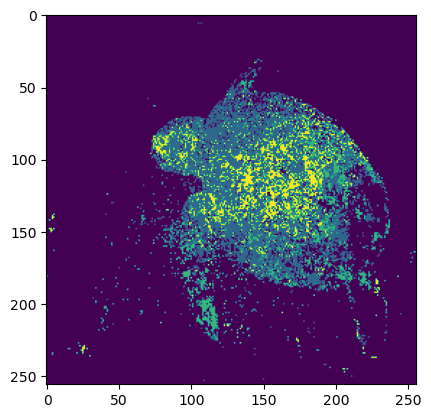

In [93]:
plt.imshow((np.array(sample_pred_RGB3_mask)).reshape(256,256))

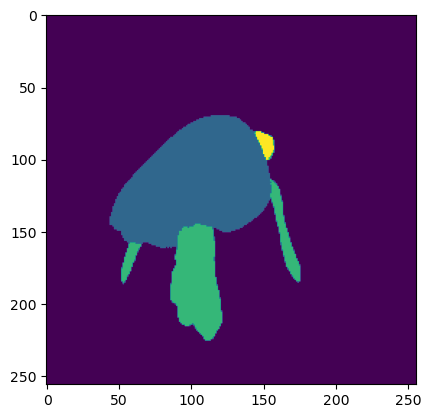

In [94]:
plt.imshow((np.array(sample_RGB3_mask_1)).reshape(256,256))

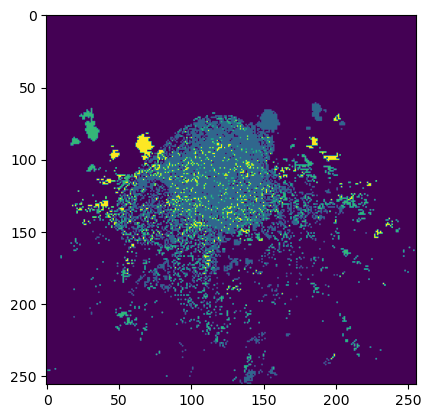

In [95]:
plt.imshow((np.array(sample_pred_RGB3_mask_1)).reshape(256,256))

Visually, it is similar without reducing number of neighbor K

Conclusion: As KNN is not suitable for image segmentation, it failed to capture the relationship between XY and affected by the noise. In some of image, the carapace may have barnacle on it. In most of image, the color of head, carapace, and flipper are similar. KNN cannot make a precise decision in our approach.